In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_member = pd.read_csv('data member.csv')

df_trans_cleaned = pd.read_csv('transaction_cleaned.csv')

trans_2021 = pd.read_csv('transaction 2021.csv')
trans_2022 = pd.read_csv('transaction 2022.csv')
trans_2023 = pd.read_csv('transaction 2023.csv')
df_trans = pd.concat([trans_2021, trans_2022, trans_2023])

In [3]:
df_member.tail(3)

,ent,original_status,join_month,join_year,sponsor
590562,H3CCCEC7,A,7,2010,H3CCC4JP
590563,H3CCCE4I,A,7,2010,H3CCC4JP
590564,H3CCCEEF,A,7,2010,H3CCC4WU


In [4]:
df_member.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590565 entries, 0 to 590564
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ent              590565 non-null  object
 1   original_status  590565 non-null  object
 2   join_month       590565 non-null  int64 
 3   join_year        590565 non-null  int64 
 4   sponsor          590565 non-null  object
dtypes: int64(2), object(3)
memory usage: 22.5+ MB


In [5]:
df_trans_cleaned.tail(3)

,payment_date,ent,center,total_amount,discount,paid_amount,trans_origin_type,product,qty
4129111,2023-07-06 00:00:00.000,TCCEQ4Z4R4Y,TKC1Z4,2500.0,NaN,2500,offline,KCQCEJ,1
4129112,2023-07-06 00:00:00.000,TCCEQEZJQ4F,TKC1Z4,2500.0,NaN,2500,offline,KCQCER,1
4129113,2023-07-06 00:00:00.000,TCCEQ434R1F,TKC1Z4,2500.0,NaN,2500,offline,KCQCER,1


In [6]:
df_trans_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4129114 entries, 0 to 4129113
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   payment_date       object 
 1   ent                object 
 2   center             object 
 3   total_amount       float64
 4   discount           float64
 5   paid_amount        int64  
 6   trans_origin_type  object 
 7   product            object 
 8   qty                int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 283.5+ MB


In [7]:
df_trans.tail(3)

,payment_date,ent,center,product_json,total_amount,discount,paid_amount,trans_origin_type
362106,2023-07-06 00:00:00.000,TCCEQ4Z4R4Y,TKC1Z4,"[{""product"":""KCQCEJ"",""qty"":1}]",2500.0,NaN,2500,offline
362107,2023-07-06 00:00:00.000,TCCEQEZJQ4F,TKC1Z4,"[{""product"":""KCQCER"",""qty"":1}]",2500.0,NaN,2500,offline
362108,2023-07-06 00:00:00.000,TCCEQ434R1F,TKC1Z4,"[{""product"":""KCQCER"",""qty"":1}]",2500.0,NaN,2500,offline


In [8]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2406316 entries, 0 to 362108
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   payment_date       object 
 1   ent                object 
 2   center             object 
 3   product_json       object 
 4   total_amount       float64
 5   discount           float64
 6   paid_amount        int64  
 7   trans_origin_type  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 165.2+ MB


In [9]:
# clean date type
df_trans_cleaned['payment_date'] = pd.to_datetime(df_trans_cleaned['payment_date'])
df_trans_cleaned['payment_ym'] = df_trans_cleaned['payment_date'].dt.to_period('M')

df_trans['payment_date'] = pd.to_datetime(df_trans['payment_date'])
df_trans['payment_ym'] = df_trans['payment_date'].dt.to_period('M')

df_member['join_ym'] = pd.to_datetime(df_member['join_year'].astype(str) + '-' + df_member['join_month'].astype(str))

In [10]:
# create feature df
df_clus = df_member[['ent']]

In [11]:
maxmonth = df_trans['payment_ym'].max()

df_trans_last3m = df_trans.loc[df_trans['payment_ym'] > (maxmonth - 3), :]
df_trans_last6m = df_trans.loc[df_trans['payment_ym'] > (maxmonth - 6), :]

df_trans_cleaned_last3m = df_trans_cleaned.loc[df_trans_cleaned['payment_ym'] > (maxmonth - 3), :]
df_trans_cleaned_last6m = df_trans_cleaned.loc[df_trans_cleaned['payment_ym'] > (maxmonth - 6), :]

In [12]:
maxdate = df_trans['payment_date'].max()
df_clus['mem_duration'] = ((maxdate - df_member['join_ym'])/np.timedelta64(1, 'M')).astype('int')

In [13]:
f0 = df_trans.groupby('ent').agg({'total_amount': ['sum',  
                                                   'count']}
                                ).reset_index()
f0.columns = ['ent', 'sale', 'num_trans']
f0['avg_ticketsize'] = f0['sale']/f0['num_trans']

f1 = df_trans_last3m.groupby('ent').agg({'total_amount': ['sum',
                                                          'count']}
                                       ).reset_index()
f1.columns = ['ent', 'sale_last3m', 'num_trans_last3m']
f1['avg_ticketsize_last3m'] = f1['sale_last3m']/f1['num_trans_last3m']

f2 = df_trans_last6m.groupby('ent').agg({'total_amount': ['sum',
                                                          'count']}
                                       ).reset_index()
f2.columns = ['ent', 'sale_last6m', 'num_trans_last6m']
f2['avg_ticketsize_last6m'] = f2['sale_last6m']/f2['num_trans_last6m']

f3 = df_trans.loc[df_trans['trans_origin_type']=='offline',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                                 ).reset_index()
f3.columns = ['ent', 'offline_sale']

f4 = df_trans_last3m.loc[df_trans_last3m['trans_origin_type']=='offline',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                                              ).reset_index()
f4.columns = ['ent', 'offline_sale_last3m']

f5 = df_trans_last6m.loc[df_trans_last6m['trans_origin_type']=='offline',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                               ).reset_index()
f5.columns = ['ent', 'offline_sale_last6m']

f6 = df_trans.loc[df_trans['trans_origin_type']=='online',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                               ).reset_index()
f6.columns = ['ent', 'online_sale']

f7 = df_trans_last3m.loc[df_trans_last3m['trans_origin_type']=='online',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                                             ).reset_index()
f7.columns = ['ent', 'online_sale_last3m']

f8 = df_trans_last6m.loc[df_trans_last6m['trans_origin_type']=='online',:].groupby('ent').agg({'total_amount': 'sum'}
                                                                                             ).reset_index()
f8.columns = ['ent', 'online_sale_last6m']

f9 = df_member.groupby('sponsor').agg({'ent':'count'}).reset_index()
f9.columns = ['ent', 'num_downline']

f10 = df_member.loc[df_member['join_ym'] > df_member['join_ym'].max()-pd.DateOffset(months=3), :].groupby('sponsor').agg({'ent':'count'}).reset_index()
f10.columns = ['ent', 'num_downline_last3m']

f11 = df_member.loc[df_member['join_ym'] > df_member['join_ym'].max()-pd.DateOffset(months=6), :].groupby('sponsor').agg({'ent':'count'}).reset_index()
f11.columns = ['ent', 'num_downline_last6m']

unique_prod = df_trans_cleaned['product'].nunique()

f12 = df_trans_cleaned.groupby('ent').agg({'product': 'nunique'}).reset_index()
f12.columns = ['ent', '%pd_variety']
f12['%pd_variety'] = f12['%pd_variety']/unique_prod

f13 = df_trans_cleaned_last3m.groupby('ent').agg({'product': 'nunique'}).reset_index()
f13.columns = ['ent', '%pd_variety_last3m']
f13['%pd_variety_last3m'] = f13['%pd_variety_last3m']/unique_prod

f14 = df_trans_cleaned_last6m.groupby('ent').agg({'product': 'nunique'}).reset_index()
f14.columns = ['ent', '%pd_variety_last6m']
f14['%pd_variety_last6m'] = f14['%pd_variety_last6m']/unique_prod

In [14]:
feature = [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14]
for i in feature:
    df_clus = df_clus.merge(i, on='ent', how='outer')

df_clus.tail(3)

,ent,mem_duration,sale,num_trans,avg_ticketsize,sale_last3m,num_trans_last3m,avg_ticketsize_last3m,sale_last6m,num_trans_last6m,...,offline_sale_last6m,online_sale,online_sale_last3m,online_sale_last6m,num_downline,num_downline_last3m,num_downline_last6m,%pd_variety,%pd_variety_last3m,%pd_variety_last6m
796543,TZZZEZCP,NaN,1962000.0,7.0,280285.714286,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014235,NaN,NaN
796544,TZZZJZ4Y,NaN,1283000.0,2.0,641500.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005338,NaN,NaN
796545,TZZZW417,NaN,50000.0,1.0,50000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001779,NaN,NaN


In [15]:
df_clus.isnull().sum()

ent                           0
mem_duration             205981
sale                     215722
num_trans                215722
avg_ticketsize           215722
sale_last3m              747559
num_trans_last3m         747559
avg_ticketsize_last3m    747559
sale_last6m              708678
num_trans_last6m         708678
avg_ticketsize_last6m    708678
offline_sale             387369
offline_sale_last3m      768201
offline_sale_last6m      743662
online_sale              454919
online_sale_last3m       764350
online_sale_last6m       737153
num_downline             680299
num_downline_last3m      788666
num_downline_last6m      781051
%pd_variety              215722
%pd_variety_last3m       747559
%pd_variety_last6m       708678
dtype: int64

In [16]:
df_clus = df_clus.dropna(subset='mem_duration')
df_clus = df_clus.fillna(0)

## Clustering

In [17]:
# remove outliner
def remove_outliner(df, column_name):
    q_low = df[column_name].quantile(0.0003) # mean-3sd
    q_hi  = df[column_name].quantile(0.9997) # mean+3sd
    df_filtered = df[(df[column_name] <= q_hi) & (df[column_name] >= q_low)]
    return df_filtered

for c in df_clus.columns[1:]:
    df_clus =  remove_outliner(df_clus, c)

In [18]:
df_clus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587040 entries, 0 to 590564
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ent                    587040 non-null  object 
 1   mem_duration           587040 non-null  float64
 2   sale                   587040 non-null  float64
 3   num_trans              587040 non-null  float64
 4   avg_ticketsize         587040 non-null  float64
 5   sale_last3m            587040 non-null  float64
 6   num_trans_last3m       587040 non-null  float64
 7   avg_ticketsize_last3m  587040 non-null  float64
 8   sale_last6m            587040 non-null  float64
 9   num_trans_last6m       587040 non-null  float64
 10  avg_ticketsize_last6m  587040 non-null  float64
 11  offline_sale           587040 non-null  float64
 12  offline_sale_last3m    587040 non-null  float64
 13  offline_sale_last6m    587040 non-null  float64
 14  online_sale            587040 non-nu

In [19]:
X = df_clus.drop('ent', axis=1)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [27]:
# kmeans = KMeans(n_clusters=2)
# labels = kmeans.fit_predict(X)

# # Calculate silhouette score
# silhouette_avg = silhouette_score(X, labels)
# print("The average silhouette score is:", silhouette_avg)

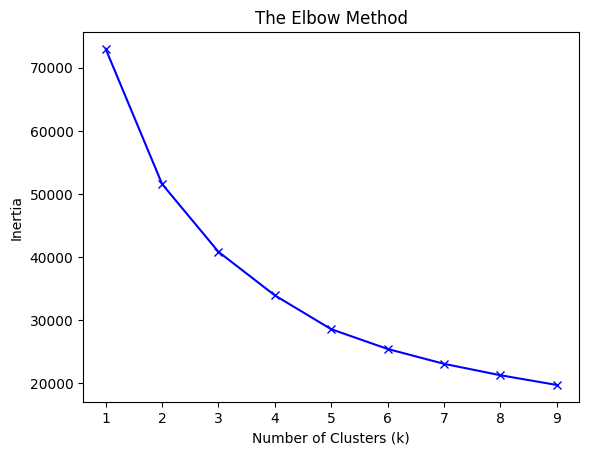

In [25]:
# Perform K-means clustering for different values of k
k_values = range(1, 10)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values against the number of clusters
plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

In [28]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_clus['Cluster'] = labels
df_clus.head(3)

,ent,mem_duration,sale,num_trans,avg_ticketsize,sale_last3m,num_trans_last3m,avg_ticketsize_last3m,sale_last6m,num_trans_last6m,...,online_sale,online_sale_last3m,online_sale_last6m,num_downline,num_downline_last3m,num_downline_last6m,%pd_variety,%pd_variety_last3m,%pd_variety_last6m,Cluster
0,UCC4CC4F,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1
1,UCC4CCEK,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,UCC4CC15,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1


In [22]:
# Create a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier on your data
clf.fit(X, labels)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Print the feature rankings
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i+1}: Feature {df_clus.columns[idx+1]}, Importance score: {importance_scores[idx]}")

Rank 1: Feature avg_ticketsize, Importance score: 0.2673298405656577
Rank 2: Feature sale, Importance score: 0.20204046484702826
Rank 3: Feature num_trans, Importance score: 0.11657722337103388
Rank 4: Feature mem_duration, Importance score: 0.08419781887051744
Rank 5: Feature %pd_variety, Importance score: 0.07152463513704367
Rank 6: Feature offline_sale, Importance score: 0.04059425889228159
Rank 7: Feature online_sale, Importance score: 0.03622990188735496
Rank 8: Feature avg_ticketsize_last3m, Importance score: 0.034201677167250706
Rank 9: Feature sale_last3m, Importance score: 0.0299463433318952
Rank 10: Feature num_trans_last3m, Importance score: 0.027350091123760637
Rank 11: Feature sale_last6m, Importance score: 0.021974121244799198
Rank 12: Feature %pd_variety_last3m, Importance score: 0.019292626687514063
Rank 13: Feature avg_ticketsize_last6m, Importance score: 0.011019249517099114
Rank 14: Feature %pd_variety_last6m, Importance score: 0.010541737240912142
Rank 15: Feature n

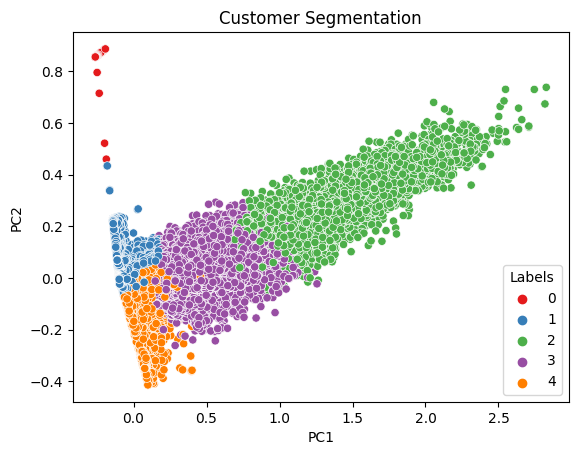

In [37]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')
plt.legend(title='Labels')

plt.show()

In [38]:
df_clus['Cluster'].value_counts()

1    264582
4    249893
3     49970
0     11851
2     10744
Name: Cluster, dtype: int64